<a href="https://colab.research.google.com/github/ParthikB/encryption/blob/master/encryption_CIFAR100_convNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
from google.colab.patches import cv2_imshow
import cv2


if torch.cuda.is_available():
  device = torch.device('cuda:0')
  running = 'GPU'
else:
  device = torch.device('cpu')
  running = 'CPU'
print(f'Running on : {running}')

Running on : GPU


### Grabbing the Data

In [2]:
train = datasets.CIFAR100('/content/CIFAR100', train=True, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))

test  = datasets.CIFAR100('/content/CIFAR100', train=False, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))

  0%|          | 0/169001437 [00:00<?, ?it/s]

169009152it [00:01, 86564259.80it/s]                               


Extracting /content/CIFAR100/cifar-100-python.tar.gz to /content/CIFAR100
Files already downloaded and verified


## Creating the Dataset Tensor

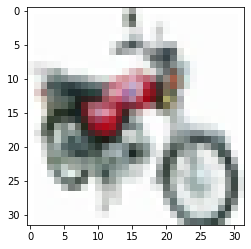

In [24]:
BATCH_SIZE = 100
HEIGHT, WIDTH, CHANNELS = 32, 32, 3
TOTAL_PIXELS = HEIGHT*WIDTH*CHANNELS

trainSet = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
testSet  = torch.utils.data.DataLoader(test,  batch_size=BATCH_SIZE, shuffle=True, num_workers=8)


# Viewing one random sample
i = np.random.randint(BATCH_SIZE) # a random sample from the first batch

for data in trainSet:
    # data --> one batch containing BATCH_SIZE samples
    x, y = data[0][i].numpy(), data[1][i]
    break

image = np.rollaxis(x, 0, 3)

plt.imshow(image) # Reshaping x from (1, Height, Width) --> (Height, Width)

## Creating the Network Structure

### Fully Connected Network (not used)

In [0]:
ENCRYPTED_DIM  = 32
ENCRYPTED_SIZE = ENCRYPTED_DIM * ENCRYPTED_DIM * CHANNELS
LAST_LAYER_INPUT_SIZE = ENCRYPTED_SIZE

class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(TOTAL_PIXELS   , ENCRYPTED_SIZE)
        self.fc2 = nn.Linear(ENCRYPTED_SIZE , ENCRYPTED_SIZE)

        self.fc3 = nn.Linear(ENCRYPTED_SIZE , ENCRYPTED_SIZE)

        self.fc4 = nn.Linear(ENCRYPTED_SIZE , ENCRYPTED_SIZE)        
        self.fc5 = nn.Linear(ENCRYPTED_SIZE , TOTAL_PIXELS)        
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))        
        x3 = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x3))        
        x = F.sigmoid(self.fc5(x))        

        
        return x, x3

print(f'''
ENCRYPTED_DIM         = {ENCRYPTED_DIM}
ENCRYPTED_SIZE        = {ENCRYPTED_SIZE}
LAST_LAYER_INPUT_SIZE = {LAST_LAYER_INPUT_SIZE}
TOTAL_PIXELS          = {TOTAL_PIXELS}
''')


ENCRYPTED_DIM         = 32
ENCRYPTED_SIZE        = 3072
LAST_LAYER_INPUT_SIZE = 3072
TOTAL_PIXELS          = 3072



### Convolutional Network

In [8]:
ENCRYPTED_DIM  = 32
ENCRYPTED_SIZE = ENCRYPTED_DIM * ENCRYPTED_DIM * CHANNELS
LAST_LAYER_INPUT_SIZE = ENCRYPTED_SIZE

class Net(nn.Module):
  def __init__(self):
    super().__init__()

    '''
    Network Structure:

    input > 
    (1)Conv2D > (2)MaxPool2D > 
    (3)Conv2D > (4)MaxPool2D > 
    (5)Conv2D > (6)MaxPool2D > 
    (7)Linear > (8)LinearOut

    '''

    # Creating the convulutional Layers
    self.conv1 = nn.Conv2d(in_channels=CHANNELS, out_channels=32,  kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=32,       out_channels=64,  kernel_size=3)
    # self.conv3 = nn.Conv2d(in_channels=64,       out_channels=128, kernel_size=3)

    self.flatten = None
    # Creating a Random dummy sample to get the Flattened Dimensions
    x = torch.randn(CHANNELS, HEIGHT, WIDTH).view(-1, CHANNELS, HEIGHT, WIDTH)
    x = self.convs(x)

    # Creating the Linear Layers
    self.fc1   = nn.Linear(self.flatten, TOTAL_PIXELS)
    self.fc2   = nn.Linear(TOTAL_PIXELS, TOTAL_PIXELS)

  def convs(self, x):

    # Creating the MaxPooling Layers
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    # x = F.relu(self.conv3(x))
    # x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=(2, 2))
    # x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=(2, 2))
    # x = F.max_pool2d(F.relu(self.conv3(x)), kernel_size=(2, 2))


    if not self.flatten:
      self.flatten = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
    return x

  # FORWARD PASS
  def forward(self, x):
    x = self.convs(x)
    x = x.view(-1, self.flatten)
    x2 = F.sigmoid(self.fc1(x))
    x = F.sigmoid(self.fc2(x2))
    return x, x2

print(f'''
ENCRYPTED_DIM         = {ENCRYPTED_DIM}
ENCRYPTED_SIZE        = {ENCRYPTED_SIZE}
LAST_LAYER_INPUT_SIZE = {LAST_LAYER_INPUT_SIZE}
TOTAL_PIXELS          = {TOTAL_PIXELS}
''')


ENCRYPTED_DIM         = 32
ENCRYPTED_SIZE        = 3072
LAST_LAYER_INPUT_SIZE = 3072
TOTAL_PIXELS          = 3072



## Load Pretrained Model

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Model Loaded!


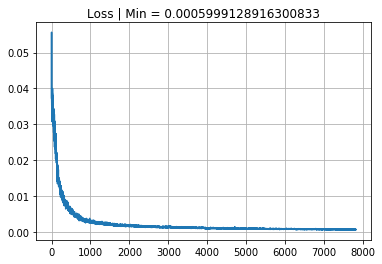

In [9]:
# Defining the Network and Optimizer base
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Loading the model file
model_state_path = '/content/drive/My Drive/Colab Notebooks/encryption/CIFAR100_convNet_model_state_1575368728__0.0005999'
model_state = torch.load(model_state_path)

# Transferring the Model States to respective variables
net.load_state_dict(model_state['state_dict'])
optimizer.load_state_dict(model_state['optimizer'])
loss_log = model_state['loss_log']

# Plotting the Loss
plt.plot(loss_log)
plt.title(f'Loss | Min = {loss_log[-1].item()}')
plt.grid(1)

print('Model Loaded!')

## Training the Network

In [0]:
CONTINUE_TRAINING = False
LEARNING_RATE = 0.001 #1e-3
EPOCHS        = 10

if not CONTINUE_TRAINING:
  net = Net().to(device)

  # Define Optimizer
  optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

  loss_log = []

# Iteration Begins
for epoch in range(EPOCHS):
    print() ; print();
    print('EPOCH :', epoch+1)
    if loss_log:
      print('Current Loss :', loss_log[-1].item())
    # Iterate over every sample in the batch
    for data in tqdm(trainSet):
        x, _ = data
        net.zero_grad()
        
        #Compute the output
        # output, layer2 = net(x.view(-1, TOTAL_PIXELS).to(device))  # Works in Fully Connected Linear Network
        output, encryptedVector = net(x.view(-1, CHANNELS, HEIGHT, WIDTH).to(device)) # Works in ConvNet
        
        # Compute Loss
        loss = F.smooth_l1_loss(output, x.view(-1, TOTAL_PIXELS).to(device))
        loss_log.append(loss)
        
        # Backpropagate
        loss.backward()
        
        # Update Parameters
        optimizer.step()
        

plt.figure(figsize=(23, 5))
plt.plot(loss_log)
plt.title(f'Loss | Min = {loss_log[-1].item()}')
plt.grid(1)

## Encryption Decryption

In [0]:
# Function to Convert Tensor into Numpy Image
def convert_to_image(input, size=None, roll=False):
  if roll == True: # Rolling from Vector to Matrix
    input = input.view(CHANNELS, size, size)

  # Moving the Channel axis from (C, H, W) -> (H, W, C)
  img = np.rollaxis(input.numpy(), 0, 3)
  return img

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



******************************************
*** Total Loss : 0.0005999128916300833 ***
******************************************


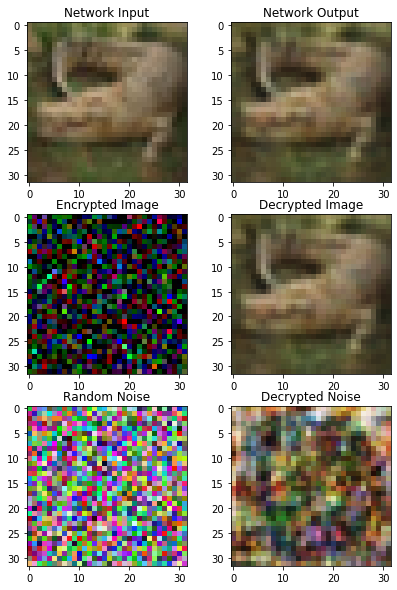

In [11]:
# Selecting a random sample from the dataset
random = np.random.randint(BATCH_SIZE)

for data in trainSet:
  sample, y = data[0][random], data[1][random]
  break

# Converting the sample into an Image to plot later.
inputImage = convert_to_image(sample)

# Passing the sample through the Network and also generating the ENCRYPTED VECTOR
with torch.no_grad():
  # networkOutput, encryptedImage = net(sample.view(-1, TOTAL_PIXELS).to(device))
  networkOutput, encryptedImage = net(sample.view(-1, CHANNELS, HEIGHT, WIDTH).to(device))
  # networkOutput = net(sample.view(-1, CHANNELS, HEIGHT, WIDTH).to(device))


# Converting the networkOutput tensor into Image (numpy array)
networkOutput  = networkOutput.cpu().detach()
networkOutput  = convert_to_image(networkOutput, size=HEIGHT, roll=True)

# Generating a random noise image to verify that ENCRYPTED VECTOR is just not random
randomNoise = torch.rand(ENCRYPTED_DIM, ENCRYPTED_DIM, CHANNELS).to(device)


# # DECRYPTING THE ENCRYPTED_VECTOR and NOISE
with torch.no_grad():
  # Passing the ENCRYPTED VECTOR through the required layers of the Network.
  # decryptedImage = F.relu(net.fc4(encryptedImage.view(-1, ENCRYPTED_SIZE)))
  decryptedImage = F.sigmoid(net.fc2(encryptedImage.view(-1, LAST_LAYER_INPUT_SIZE)))

  # Passing the Random Noise Image through the required layers of the Network.
  # randomNoiseDecrypted = F.relu(net.fc4(randomNoise.view(-1, ENCRYPTED_SIZE)))
  randomNoiseDecrypted = F.sigmoid(net.fc2(randomNoise.view(-1, LAST_LAYER_INPUT_SIZE)))

# # Converting the ENCRYPTED VECTOR into Image Format
encryptedImage  = encryptedImage.cpu().detach()
encryptedImage  = convert_to_image(encryptedImage, size=ENCRYPTED_DIM, roll=True)

# Converting the DECRYPTED VECTOR into Image Format
decryptedImage  = decryptedImage.cpu().detach()
decryptedImage  = convert_to_image(decryptedImage, size=HEIGHT, roll=True)

# Converting the Random Noise Decrypted Vector into Image Format
randomNoiseDecrypted  = randomNoiseDecrypted.cpu().detach()
randomNoiseDecrypted  = convert_to_image(randomNoiseDecrypted, size=HEIGHT, roll=True)


# PLOTTING THE OUTPUTS
plt.figure(figsize=(14, 10))

plt.subplot(3, 4, 1)
plt.imshow(inputImage)
plt.title('Network Input')

plt.subplot(3, 4, 2)
plt.imshow(networkOutput)
plt.title('Network Output')

plt.subplot(3, 4, 5)
plt.imshow(encryptedImage)
plt.title('Encrypted Image')

plt.subplot(3, 4, 6)
plt.imshow(decryptedImage)
plt.title('Decrypted Image')

plt.subplot(3, 4, 9)
plt.imshow(randomNoise.cpu())
plt.title('Random Noise')

plt.subplot(3, 4, 10)
plt.imshow(randomNoiseDecrypted)
plt.title('Decrypted Noise')


print(f'''
******************************************
*** Total Loss : {loss_log[-1].item()} ***
******************************************''')

In [12]:
print('Difference between Network output and Decrypted Image :', np.sum(networkOutput - decryptedImage))

Difference between Network output and Decrypted Image : 0.0


# Saving the Model

In [11]:
SAVE_MODEL = False

if SAVE_MODEL:

  from google.colab import drive
  drive.mount('/content/drive')

  model_state = {
      'dataset'   : 'CIFAR100_convNet',
      'epochs'    : 10,
      'loss_type' : 'smooth_l1_loss',
      'loss_log'  : loss_log,
      'state_dict': net.state_dict(),
      'optimizer' : optimizer.state_dict(),
  }

  torch.save(model_state, f'/content/drive/My Drive/Colab Notebooks/encryption/' + model_state['dataset'] + f'_model_state_{int(time.time())}__{np.round(loss_log[-1].item(), 7)}')
  print(f'Model [' + model_state['dataset'] + f'_model_state_{int(time.time())}__{np.round(loss_log[-1].item(), 7)}] saved successfully!')

Model [CIFAR100_convNet_model_state_1575368737__0.0005999] saved successfully!


# Accuracy Check

In [0]:
BATCH_SIZE = 100

trainSet = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=False)
testSet  = torch.utils.data.DataLoader(test,  batch_size=BATCH_SIZE, shuffle=False)

In [17]:
# Saving the network output/decrypted output of every sample in the dataset.
outputs = []

with torch.no_grad():
    for data in tqdm(trainSet):
        x, y = data
        testOutput, encryptedImage = net(x.view(-1, CHANNELS, HEIGHT, WIDTH).to(device))

        # Because Decrypted Image = testOutput. So, to save time, we'll just use the testOutput for verification.
        outputs.append(testOutput.view(-1, CHANNELS, HEIGHT, WIDTH))

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 500/500 [00:24<00:00, 20.41it/s]


## Loading Pretrained Model

In [0]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from collections import OrderedDict


model_urls = {
    'cifar10' : 'http://ml.cs.tsinghua.edu.cn/~chenxi/pytorch-models/cifar10-d875770b.pth',
    'cifar100': 'http://ml.cs.tsinghua.edu.cn/~chenxi/pytorch-models/cifar100-3a55a987.pth',
}

class CIFAR(nn.Module):
    def __init__(self, features, n_channel, num_classes):
        super(CIFAR, self).__init__()
        assert isinstance(features, nn.Sequential), type(features)
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(n_channel, num_classes)
        )
        # print(self.features)
        # print(self.classifier)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for i, v in enumerate(cfg):
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            padding = v[1] if isinstance(v, tuple) else 1
            out_channels = v[0] if isinstance(v, tuple) else v
            conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=padding)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(out_channels, affine=False), nn.ReLU()]
            else:
                layers += [conv2d, nn.ReLU()]
            in_channels = out_channels
    return nn.Sequential(*layers)

def cifar10(n_channel, pretrained=None):
    cfg = [n_channel, n_channel, 'M', 2*n_channel, 2*n_channel, 'M', 4*n_channel, 4*n_channel, 'M', (8*n_channel, 0), 'M']
    layers = make_layers(cfg, batch_norm=True)
    model = CIFAR(layers, n_channel=8*n_channel, num_classes=10)
    if pretrained is not None:
        m = model_zoo.load_url(model_urls['cifar10'])
        state_dict = m.state_dict() if isinstance(m, nn.Module) else m
        assert isinstance(state_dict, (dict, OrderedDict)), type(state_dict)
        model.load_state_dict(state_dict)
    return model

def cifar100(n_channel, pretrained=None):
    cfg = [n_channel, n_channel, 'M', 2*n_channel, 2*n_channel, 'M', 4*n_channel, 4*n_channel, 'M', (8*n_channel, 0), 'M']
    layers = make_layers(cfg, batch_norm=True)
    model = CIFAR(layers, n_channel=8*n_channel, num_classes=100)
    if pretrained is not None:
        m = model_zoo.load_url(model_urls['cifar100'])
        state_dict = m.state_dict() if isinstance(m, nn.Module) else m
        assert isinstance(state_dict, (dict, OrderedDict)), type(state_dict)
        model.load_state_dict(state_dict)
    return model

In [15]:
# Loading the CIFAR100 Classifier model
classifier_net = cifar100(128, pretrained='log/cifar100/best-135.pth').to(device)

print('Model Loaded!')

Downloading: "http://ml.cs.tsinghua.edu.cn/~chenxi/pytorch-models/cifar100-3a55a987.pth" to /root/.cache/torch/checkpoints/cifar100-3a55a987.pth
100%|██████████| 35.9M/35.9M [00:48<00:00, 773kB/s]

Model Loaded!


In [19]:
correct, total = 0, 0
decrypted_correct, decrypted_total = 0, 0

with torch.no_grad():
    
    # Train Accuracy
    for data in tqdm(zip(trainSet, outputs)):
        original, net_output = data
        x, y = original

        # Predicting the classes of the original Input images
        original_output  = classifier_net(x.view(-1, CHANNELS, HEIGHT, WIDTH).to(device))
        # Predicting the classes of the Decrypted images fed as Input images
        decrypted_output = classifier_net(net_output.view(-1, CHANNELS, HEIGHT, WIDTH).to(device))
        
        # Correct += 1 if the predicted class is same as the original class
        for idx, i in enumerate(original_output):
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1

        # Correct += 1 if the predicted class is same as the original class        
        for idx, i in enumerate(decrypted_output):
            if torch.argmax(i) == y[idx]:
                decrypted_correct += 1
            decrypted_total += 1

    trainAccuracy = round(correct/total *100, 2)
    decrypted_trainAccuracy = round(decrypted_correct/decrypted_total *100, 2)
    
    # Test Accuracy
    for data in tqdm(zip(testSet, outputs)):
        original, net_output = data
        x, y = original

        # Predicting the classes of the original Input images
        original_output  = classifier_net(x.view(-1, CHANNELS, HEIGHT, WIDTH).to(device))
        # Predicting the classes of the Decrypted images fed as Input images
        decrypted_output = classifier_net(net_output.view(-1, CHANNELS, HEIGHT, WIDTH).to(device))
        
        # Correct += 1 if the predicted class is same as the original class        
        for idx, i in enumerate(original_output):
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1
        
        # Correct += 1 if the predicted class is same as the original class        
        for idx, i in enumerate(decrypted_output):
            if torch.argmax(i) == y[idx]:
                decrypted_correct += 1
            decrypted_total += 1

    testAccuracy = round(correct/total *100, 2)
    decrypted_testAccuracy = round(decrypted_correct/decrypted_total *100, 2)

print()
print('Train Accuracy           :', trainAccuracy, '%')
print('Test Accuracy            :', testAccuracy, '%')
print('Decrypted Train Accuracy :', decrypted_trainAccuracy, '%')
print('Decrypted Test Accuracy  :', decrypted_testAccuracy, '%')

500it [01:01,  8.19it/s]
100it [00:12,  8.15it/s]


Train Accuracy           : 99.82 %
Test Accuracy            : 95.2 %
Decrypted Train Accuracy : 89.13 %
Decrypted Test Accuracy  : 74.4 %
